In [1]:
import sys, os, import_ipynb
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(os.path.join(sys.path[0], '..')))
import common.SGC as SGC
import common.functions as fun
import createCostsMatrix as ccm

importing Jupyter notebook from /mnt/DANE/Dokumenty/Informatyka/Projekty/optimal-egc/Notebooks/common/SGC.ipynb
importing Jupyter notebook from /mnt/DANE/Dokumenty/Informatyka/Projekty/optimal-egc/Notebooks/common/functions.ipynb
importing Jupyter notebook from createCostsMatrix.ipynb


In [2]:
def calculateCodeCost(codonsList, aaList, mutationCostDict):
    """
    codonsList and aaList are lists both with length 'k'. 
    aa on position 'i' in aaList is coded by codon on the same position i codonsList.
    In lists are only standard aa's. Codons are encoded using strings with 3 chars, 
    and aa using strings with 1 char.
    """
    codonDict=dict(zip(codonsList, aaList))
    cost=0
    nucleotideList=['A','T','C','G']
    for codon in codonsList:
        currentAA=codonDict[codon]
        if currentAA =='X':
            continue
        for pos in range(3):
            for nuc in nucleotideList:
                neighCodon=list(codon)
                neighCodon[pos]=nuc
                neighCodon=''.join(neighCodon)
                try:
                    neighAA=codonDict[neighCodon]
                    if neighAA=='X':
                        # tabel is normalized by max value so max value is 1
                        cost+=1
                        continue
                    cost+=mutationCostDict.getMutationCost(currentAA, neighAA)
                except KeyError:
                    pass
    #we devided cost by two becouse each cost is countet two times
    cost/=2
    return cost

In [3]:
def findMinimumCodeCostForDiffrentOrderings(setOfOrderings, k, mutationCostDict, normalizeByK=False):
    """
    Take three arguments first is set of all ordering which should be checked. 
    Ordering is pair ot nucleotide order and position order.
    Second is length of genereted code which we should take into accont.
    Third is instance of aaMutationCostDict class.
    """
    costsList=[]
    ordersList=[]
    for nucOrder,posOrder in setOfOrderings:
        codonsList,aaList=fun.generateCodonsAndAA(nucOrder, posOrder)
        codonsList=codonsList[:k]
        aaList=aaList[:k]
        cost=calculateCodeCost(codonsList, aaList, mutationCostDict)
        if normalizeByK:
            cost/=k
        costsList.append(cost)
        ordersList.append((nucOrder,posOrder))
    costsArray=np.array(costsList)
    minCost=costsArray.min()
    minCostIndexs=np.arange(costsArray.size)[costsArray==minCost]
    ordersSet=set()
    for i in minCostIndexs:
        ordersSet.add(ordersList[i])
    return costsArray[minCostIndexs[0]],ordersSet

In [4]:
def plotMimimumCodeCostsForSeqentialSizes(mutationCostDict, startK=28, normalizeByK=False):
    costsList=[]
    bestOrderings=[]
    allMinCodes=fun.generateAllMinCodes()
    setOfConsideredCodes=set()
    for k in range(0, startK):
        if k in allMinCodes:
            setOfConsideredCodes|=allMinCodes[k]
    for k in range(startK, 65):
        if k in allMinCodes:
            setOfConsideredCodes|=allMinCodes[k]
        cost, order = findMinimumCodeCostForDiffrentOrderings(setOfConsideredCodes, k, mutationCostDict, 
                                                              normalizeByK=normalizeByK)
        costsList.append(cost)
        bestOrderings.append(order)
    #plt.xlabel("k")
    #plt.ylabel("cost")
    #plt.title(mutationCostDict.name)
    plt.plot(np.arange(startK,65), costsList, label=mutationCostDict.name)
    return costsList, bestOrderings

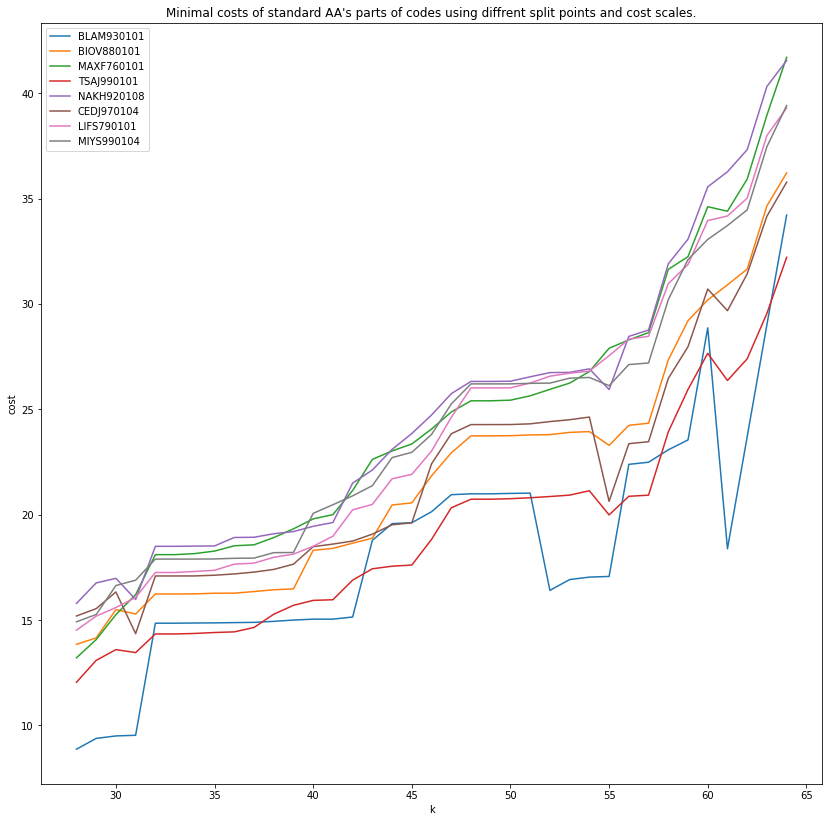

In [5]:
costsDictList=ccm.loadMutationCostDicts()
plt.gcf().set_size_inches((14,14))
bestCostAAOrderingList=[]
for mutationCostDict in costsDictList:
    costList, orderingList=plotMimimumCodeCostsForSeqentialSizes(mutationCostDict)
    bestCostAAOrderingList.append(orderingList)
plt.legend()
plt.xlabel("k")
plt.ylabel("cost")
plt.title("Minimal costs of standard AA's parts of codes using diffrent split points and cost scales.")
plt.savefig("Obrazy/costsOfCodes.png",dpi=1000)

In [24]:
with open("Wyniki/bestAACostOrderList.txt","w") as file:
    print(bestCostAAOrderingList, file=file)

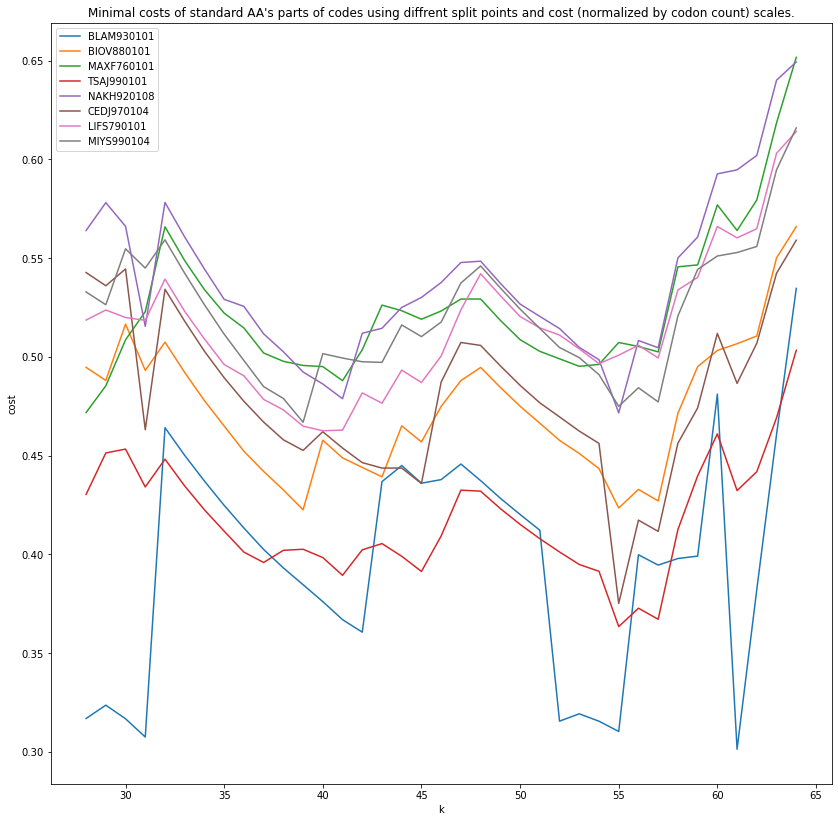

In [25]:
plt.gcf().set_size_inches((14,14))
bestCostAAOrderingListNormalizedByK=[]
for mutationCostDict in costsDictList:
    costList, orderingList=plotMimimumCodeCostsForSeqentialSizes(mutationCostDict, normalizeByK=True)
    bestCostAAOrderingListNormalizedByK.append(orderingList)
plt.legend()
plt.xlabel("k")
plt.ylabel("cost")
plt.title("Minimal costs of standard AA's parts of codes using diffrent split points and cost (normalized by codon count) scales.")
plt.savefig("Obrazy/costsNormalizedByCodonCountOfCodes.png",dpi=1000)

In [5]:
def wyznaczNajlepszekodyPodWzgledemConductance(startK=28):
    allMinCodes=fun.generateAllMinCodes()
    setOfConsideredCodes=set()
    listOfBestOrders=[]
    for k in range(0, startK):
        if k in allMinCodes:
            setOfConsideredCodes|=allMinCodes[k]
    for k in range(startK, 65):
        if k in allMinCodes:
            setOfConsideredCodes|=allMinCodes[k]
        minCond=200
        bestOrder=set()
        for nucOrd, posOrd in setOfConsideredCodes:
            codons, aa=fun.generateCodonsAndAA(nucOrd, posOrd)
            cond=fun.avarangeConductance(codons[:k], aa[:k])
            if cond<minCond:
                minCond=cond
                bestOrder=set()
            if cond==minCond:
                bestOrder.add((nucOrd, posOrd))
        listOfBestOrders.append(bestOrder)
    return listOfBestOrders

In [6]:
bestCondOrderingList=wyznaczNajlepszekodyPodWzgledemConductance()

In [8]:
with open("Wyniki/bestConductanceOrderList.txt","w") as file:
    print(bestCondOrderingList, file=file)

In [7]:
commonBestList=[]
for k in range(len(bestCostAAOrderingList)):
    commonBestList.append([])
    for i in range(len(bestCondOrderingList)):
        if len((bestCondOrderingList[i] & bestCostAAOrderingList[k][i]))>0:
            commonBestList[-1].append(i+28)

NameError: name 'bestCostAAOrderingList' is not defined

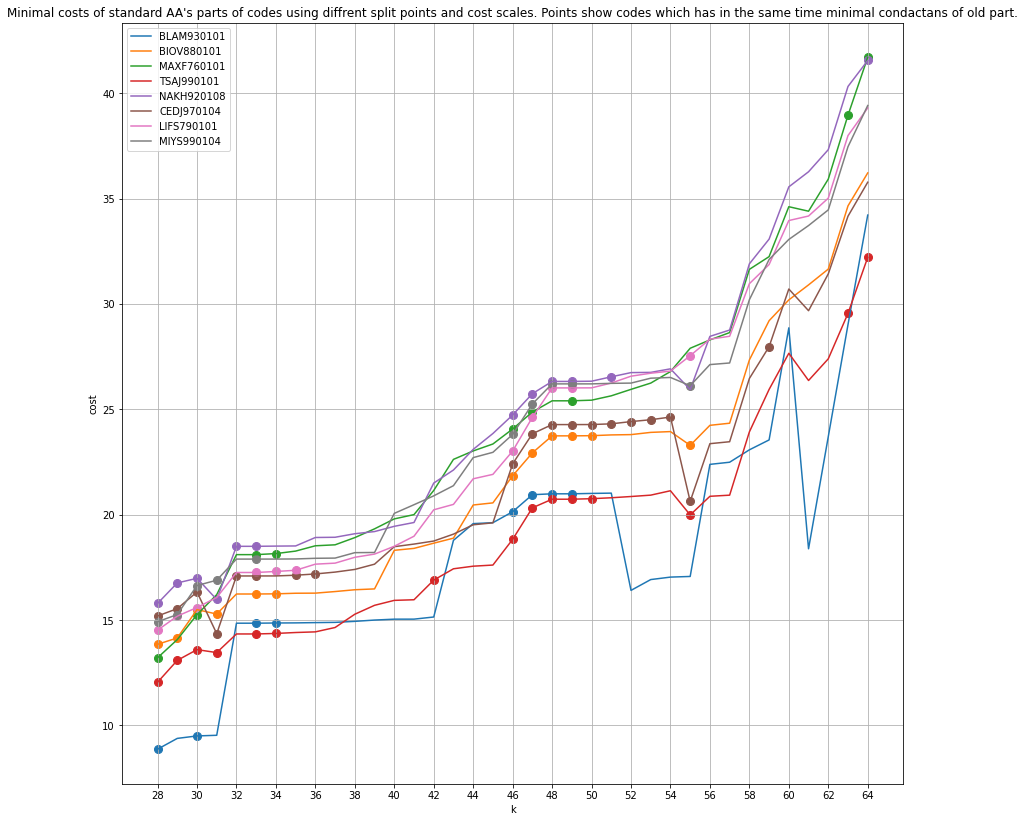

In [10]:
plt.gcf().set_size_inches((14,14))
for i in range(len(costsDictList)):
    mutationCostDict=costsDictList[i]
    costList, orderingList=plotMimimumCodeCostsForSeqentialSizes(mutationCostDict)
    costsOfCommons=[]
    for j in commonBestList[i]:
        costsOfCommons.append(costList[j-28])
    plt.scatter(commonBestList[i], costsOfCommons, s=64)
plt.legend()
plt.xlabel("k")
plt.ylabel("cost")
plt.xticks(range(28,65,2))
plt.grid(True)
plt.title("Minimal costs of standard AA's parts of codes using diffrent split points and cost scales. Points show codes which has in the same time minimal condactans of old part.")
plt.savefig("Obrazy/costsOfCodesWithCommonOrderings.png",dpi=1000)

In [31]:
commonWithNormalizedByKBestList=[]
for k in range(len(bestCostAAOrderingListNormalizedByK)):
    commonWithNormalizedByKBestList.append([])
    for i in range(len(bestCondOrderingList)):
        if len((bestCondOrderingList[i] & bestCostAAOrderingListNormalizedByK[k][i]))>0:
            commonWithNormalizedByKBestList[-1].append(i+28)

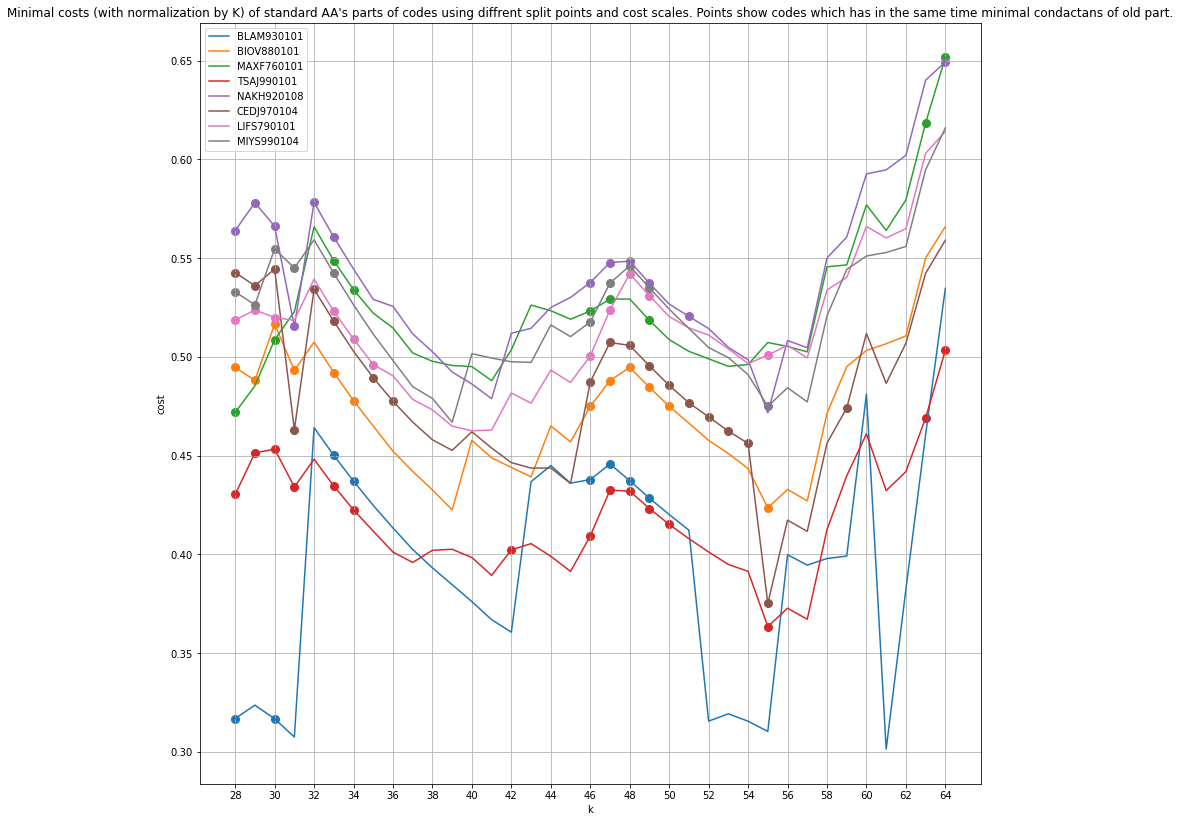

In [32]:
plt.gcf().set_size_inches((14,14))
for i in range(len(costsDictList)):
    mutationCostDict=costsDictList[i]
    costList, orderingList=plotMimimumCodeCostsForSeqentialSizes(mutationCostDict, normalizeByK=True)
    costsOfCommons=[]
    for j in commonWithNormalizedByKBestList[i]:
        costsOfCommons.append(costList[j-28])
    plt.scatter(commonWithNormalizedByKBestList[i], costsOfCommons, s=64)
plt.legend()
plt.xlabel("k")
plt.ylabel("cost")
plt.xticks(range(28,65,2))
plt.grid(True)
plt.title("Minimal costs (with normalization by K) of standard AA's parts of codes using diffrent split points and cost scales. Points show codes which has in the same time minimal condactans of old part.")
plt.savefig("Obrazy/costsOfCodesNormalizedByKWithCommonOrderings.png",dpi=1000)

In [17]:
optimalInSenseOfBalanseOfCodonsBlock=[((28, 16),
  (0.8829113924050636,
   0.8611111111111114,
   0.9753086419753086,
   [3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
   ('T', 'G', 'A', 'C'),
   (3, 2, 1))),
 ((29, 16),
  (0.894886363636364,
   0.8680555555555558,
   0.9700176366843033,
   [3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
   ('G', 'T', 'A', 'C'),
   (3, 2, 1))),
 ((30, 16),
  (0.9053375912408761,
   0.8750000000000002,
   0.9664902998236332,
   [3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
   ('T', 'G', 'A', 'C'),
   (3, 2, 1))),
 ((31, 16),
  (0.920925414364641,
   0.8819444444444446,
   0.9576719576719577,
   [3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
   ('C', 'G', 'A', 'T'),
   (2, 3, 1))),
 ((32, 16),
  (0.9298892988929893,
   0.8888888888888892,
   0.9559082892416225,
   [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
   ('G', 'C', 'T', 'A'),
   (3, 2, 1))),
 ((33, 16),
  (0.9423701298701301,
   0.8958333333333336,
   0.9506172839506173,
   [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1],
   ('C', 'G', 'A', 'T'),
   (3, 2, 1))),
 ((34, 16),
  (0.9549906716417913,
   0.902777777777778,
   0.9453262786596119,
   [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1],
   ('C', 'G', 'A', 'T'),
   (3, 2, 1))),
 ((35, 16),
  (0.967753283302064,
   0.9097222222222224,
   0.9400352733686067,
   [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1],
   ('C', 'G', 'A', 'T'),
   (3, 2, 1))),
 ((36, 16),
  (0.9806603773584907,
   0.9166666666666669,
   0.9347442680776015,
   [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1],
   ('G', 'T', 'A', 'C'),
   (2, 3, 1))),
 ((37, 16),
  (0.9937144212523721,
   0.9236111111111113,
   0.9294532627865961,
   [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1],
   ('G', 'T', 'C', 'A'),
   (2, 3, 1))),
 ((38, 16),
  (1.0011859582542695,
   0.9305555555555557,
   0.9294532627865961,
   [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1],
   ('G', 'C', 'T', 'A'),
   (3, 2, 1))),
 ((39, 16),
  (1.0042745135084075,
   0.9375000000000001,
   0.9335097001763669,
   [2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1],
   ('T', 'G', 'A', 'C'),
   (3, 2, 1))),
 ((40, 16),
  (1.0169008735282947,
   0.9444444444444445,
   0.9287477954144622,
   [2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1],
   ('T', 'G', 'A', 'C'),
   (3, 2, 1))),
 ((41, 16),
  (1.0302473262032086,
   0.951388888888889,
   0.9234567901234568,
   [2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   ('G', 'T', 'A', 'C'),
   (3, 2, 1))),
 ((42, 16),
  (1.045756351039261,
   0.9583333333333334,
   0.9164021164021166,
   [2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   ('T', 'G', 'A', 'C'),
   (3, 2, 1))),
 ((43, 16),
  (1.059451219512195,
   0.9652777777777778,
   0.9111111111111112,
   [2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   ('T', 'G', 'A', 'C'),
   (3, 2, 1))),
 ((44, 16),
  (1.073306074766355,
   0.9722222222222222,
   0.9058201058201059,
   [2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   ('A', 'T', 'G', 'C'),
   (3, 2, 1))),
 ((45, 16),
  (1.0862600273918996,
   0.9791666666666666,
   0.9014109347442681,
   [2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   ('T', 'A', 'G', 'C'),
   (3, 2, 1))),
 ((46, 16),
  (1.1004231450501867,
   0.9861111111111112,
   0.896119929453263,
   [2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   ('G', 'T', 'A', 'C'),
   (3, 2, 1))),
 ((47, 16),
  (1.1147545040586022,
   0.9930555555555556,
   0.8908289241622576,
   [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   ('A', 'T', 'G', 'C'),
   (2, 3, 1))),
 ((48, 16),
  (1.129257120095598,
   1.0,
   0.8855379188712524,
   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   ('G', 'A', 'T', 'C'),
   (3, 2, 1))),
 ((49, 15),
  (1.1358173076923075,
   1.0,
   0.8804232804232806,
   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   ('T', 'C', 'G', 'A'),
   (2, 3, 1))),
 ((50, 14),
  (1.1358173076923075,
   1.0,
   0.8804232804232806,
   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   ('T', 'G', 'C', 'A'),
   (2, 3, 1))),
 ((51, 13),
  (1.140845070422535,
   1.0,
   0.8765432098765434,
   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   ('T', 'C', 'G', 'A'),
   (2, 3, 1))),
 ((52, 4),
  (0.8963414634146342,
   0.7777777777777778,
   0.8677248677248677,
   [3, 3, 3, 3],
   ('A', 'G', 'T', 'C'),
   (3, 1, 2))),
 ((52, 12),
  (1.1477732793522266,
   1.0,
   0.871252204585538,
   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   ('G', 'A', 'T', 'C'),
   (3, 2, 1))),
 ((53, 4),
  (0.9417525773195877,
   0.8055555555555556,
   0.8553791887125219,
   [3, 3, 3, 2],
   ('A', 'T', 'G', 'C'),
   (1, 3, 2))),
 ((53, 11),
  (1.1547861507128308,
   1.0,
   0.8659611992945329,
   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   ('G', 'A', 'T', 'C'),
   (3, 2, 1))),
 ((54, 4),
  (0.975232198142415,
   0.8333333333333334,
   0.8544973544973544,
   [3, 3, 2, 2],
   ('A', 'T', 'G', 'C'),
   (1, 3, 2))),
 ((54, 10),
  (1.156670746634027,
   1.0,
   0.8645502645502645,
   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   ('G', 'T', 'C', 'A'),
   (3, 2, 1))),
 ((55, 4),
  (1.0025667351129364,
   0.861111111111111,
   0.8589065255731922,
   [3, 2, 2, 2],
   ('A', 'T', 'C', 'G'),
   (1, 3, 2))),
 ((55, 9),
  (1.1637931034482758,
   1.0,
   0.8592592592592593,
   [1, 1, 1, 1, 1, 1, 1, 1, 1],
   ('G', 'T', 'C', 'A'),
   (3, 2, 1))),
 ((56, 4),
  (1.0391752577319586,
   0.8888888888888888,
   0.8553791887125222,
   [2, 2, 2, 2],
   ('G', 'C', 'T', 'A'),
   (3, 1, 2))),
 ((56, 8),
  (1.1710037174721186,
   1.0,
   0.8539682539682542,
   [1, 1, 1, 1, 1, 1, 1, 1],
   ('T', 'G', 'C', 'A'),
   (3, 2, 1))),
 ((57, 4),
  (1.0783195020746885,
   0.9166666666666666,
   0.8500881834215169,
   [2, 2, 2, 1],
   ('C', 'G', 'T', 'A'),
   (3, 1, 2))),
 ((57, 7),
  (1.1763485477178421,
   1.0,
   0.8500881834215169,
   [1, 1, 1, 1, 1, 1, 1],
   ('T', 'G', 'C', 'A'),
   (3, 2, 1))),
 ((58, 4),
  (1.1179540709812106,
   0.9444444444444444,
   0.8447971781305116,
   [2, 2, 1, 1],
   ('G', 'C', 'T', 'A'),
   (3, 1, 2))),
 ((58, 6),
  (1.183716075156576,
   1.0,
   0.8447971781305116,
   [1, 1, 1, 1, 1, 1],
   ('G', 'T', 'C', 'A'),
   (3, 2, 1))),
 ((59, 4),
  (1.1580882352941173,
   0.9722222222222222,
   0.8395061728395063,
   [2, 1, 1, 1],
   ('C', 'G', 'T', 'A'),
   (3, 1, 2))),
 ((59, 5),
  (1.191176470588235,
   1.0,
   0.8395061728395063,
   [1, 1, 1, 1, 1],
   ('T', 'G', 'C', 'A'),
   (3, 2, 1))),
 ((60, 4),
  (1.198731501057082,
   1.0,
   0.8342151675485011,
   [1, 1, 1, 1],
   ('G', 'C', 'T', 'A'),
   (3, 1, 2))),
 ((61, 1),
  (0.9524838012958965,
   0.7777777777777778,
   0.8165784832451498,
   [3],
   ('C', 'A', 'G', 'T'),
   (1, 2, 3))),
 ((61, 3),
  (1.206382978723404,
   1.0,
   0.8289241622574958,
   [1, 1, 1],
   ('C', 'G', 'T', 'A'),
   (3, 1, 2))),
 ((62, 1),
  (1.081545064377682,
   0.8888888888888888,
   0.8218694885361554,
   [2],
   ('C', 'T', 'A', 'G'),
   (2, 1, 3))),
 ((62, 2),
  (1.2141327623126335,
   1.0,
   0.8236331569664905,
   [1, 1],
   ('G', 'C', 'T', 'A'),
   (3, 1, 2))),
 ((63, 1),
  (1.2246220302375805,
   1.0,
   0.8165784832451501,
   [1],
   ('C', 'T', 'A', 'G'),
   (2, 1, 3))),
 ((64, 0), (0.0, 0, 0.8112874779541445, [], ('A', 'T', 'G', 'C'), (2, 1, 3)))]

In [18]:
listOfOrdersBestInSensOfBalanceOfBlocks=[set() for i in range(28,65)]
for i in optimalInSenseOfBalanseOfCodonsBlock:
    k, nrOfBlocks= i[0]
    nucOrd=i[1][4]
    posOrd=i[1][5]
    listOfOrdersBestInSensOfBalanceOfBlocks[k-28].add((nucOrd, posOrd))

In [19]:
listOfCommonOrdersForBalanceAndAACost=[]
for k in range(len(bestCostAAOrderingList)):
    listOfCommonOrdersForBalanceAndAACost.append([])
    for i in range(len(listOfOrdersBestInSensOfBalanceOfBlocks)):
        if len((listOfOrdersBestInSensOfBalanceOfBlocks[i] & bestCostAAOrderingList[k][i]))>0:
            listOfCommonOrdersForBalanceAndAACost[-1].append(i+28)

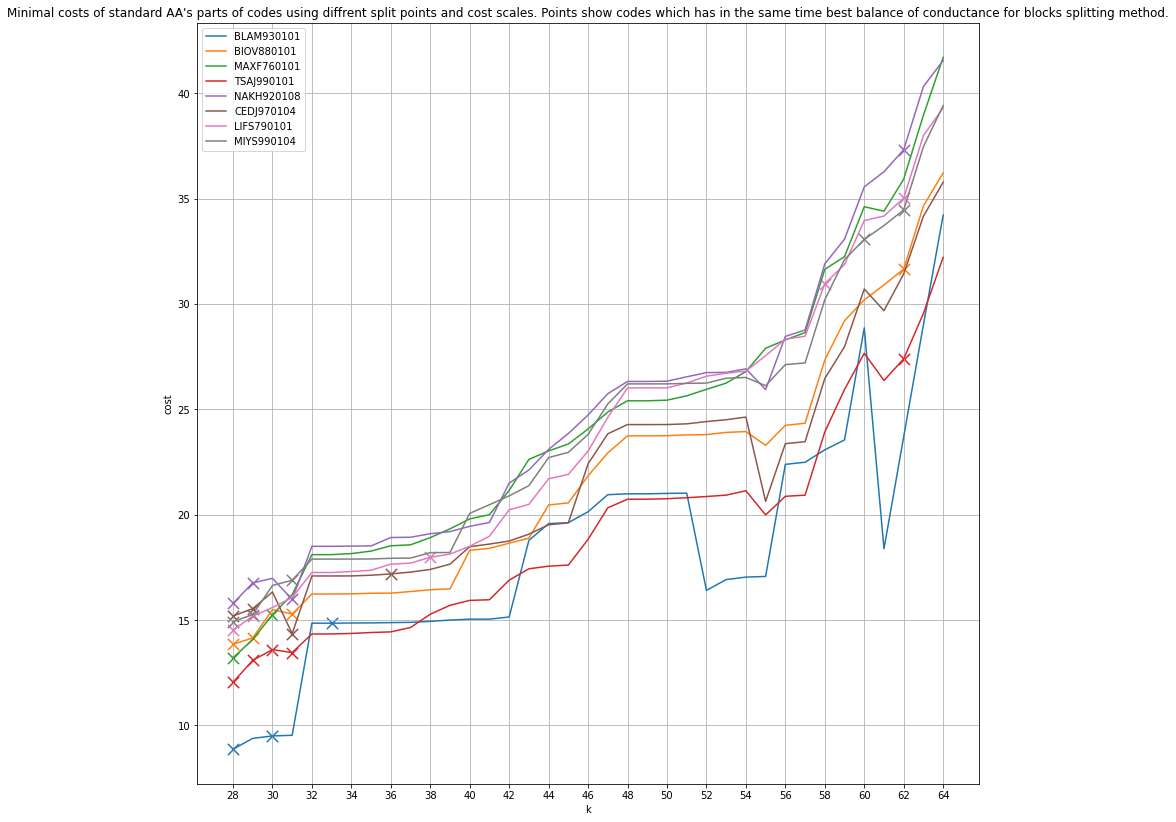

In [21]:
plt.gcf().set_size_inches((14,14))
for i in range(len(costsDictList)):
    mutationCostDict=costsDictList[i]
    costList, orderingList=plotMimimumCodeCostsForSeqentialSizes(mutationCostDict)
    costsOfCommons=[]
    for j in listOfCommonOrdersForBalanceAndAACost[i]:
        costsOfCommons.append(costList[j-28])
    plt.scatter(listOfCommonOrdersForBalanceAndAACost[i], costsOfCommons, marker='x', s=128)
plt.legend()
plt.xlabel("k")
plt.ylabel("cost")
plt.xticks(range(28,65,2))
plt.grid(True)
plt.title("Minimal costs of standard AA's parts of codes using diffrent split points and cost scales. Points show codes which has in the same time best balance of conductance for blocks splitting method.")
plt.savefig("Obrazy/costsOfCodesWithCommonOrderingsForAACostsAndBalances.png",dpi=1000)

#### Test if there is point where all 8 scales has the same minimal code generator

In [22]:
for i in range(28, 65):
    commonSet=set(bestCostAAOrderingList[0][i-28])
    for k in range(1,8):
        commonSet&=bestCostAAOrderingList[k][i-28]
    if len(commonSet)>0:
        print(i)

28


#### For each k find bigest group which has the same optimal order

In [23]:
listOfScalesIndexesWhichAreInBigestGroupWithTheSameOptimalOrder=[]
for i in range(28,65):
    listOfScalesIndexesWhichAreInBigestGroupWithTheSameOptimalOrder.append([])
    dictionaryOfOccurences={}
    for k in range(0,8):
        setWithBestOrders=bestCostAAOrderingList[k][i-28]
        for order in setWithBestOrders:
            if order not in dictionaryOfOccurences:
                dictionaryOfOccurences[order]=[]
            dictionaryOfOccurences[order].append(k)
    maxSize=0
    for order in dictionaryOfOccurences:
        if len(dictionaryOfOccurences[order])>maxSize:
            maxSize=len(dictionaryOfOccurences[order])
            listOfScalesIndexesWhichAreInBigestGroupWithTheSameOptimalOrder[-1]=dictionaryOfOccurences[order]

In [24]:
listOfSizesInWhichThisOrderBelongToBigestGroup=[[] for i in range(8)]
for i in range(len(listOfScalesIndexesWhichAreInBigestGroupWithTheSameOptimalOrder)):
    sublist=listOfScalesIndexesWhichAreInBigestGroupWithTheSameOptimalOrder[i]
    for scaleIndex in sublist:
        listOfSizesInWhichThisOrderBelongToBigestGroup[scaleIndex].append(i+28)

In [25]:
listOfScalesIndexesWhichAreInBigestGroupWithTheSameOptimalOrder

[[0, 1, 2, 3, 4, 5, 6, 7],
 [1, 3, 4, 5, 6, 7],
 [1, 4, 5, 6, 7],
 [1, 3, 4, 5, 7],
 [1, 4, 5, 6, 7],
 [1, 4, 5, 6, 7],
 [1, 3, 6],
 [0],
 [0, 1, 3, 7],
 [0, 1, 2, 7],
 [1, 3, 4, 7],
 [1, 6, 7],
 [0, 2],
 [0, 2],
 [0, 2],
 [1, 3, 5],
 [0, 2, 7],
 [1, 3, 5, 7],
 [0, 4, 5],
 [0, 6, 7],
 [0, 3, 5],
 [0, 3, 5, 7],
 [0, 6, 7],
 [0, 1, 2, 7],
 [1, 2, 7],
 [1, 4, 6, 7],
 [1, 4, 6, 7],
 [1, 3, 5, 6, 7],
 [1, 3, 5, 6, 7],
 [1, 3, 5, 6, 7],
 [3, 5, 7],
 [1, 3],
 [1, 6],
 [2, 3],
 [1, 4, 6, 7],
 [0],
 [3, 4]]

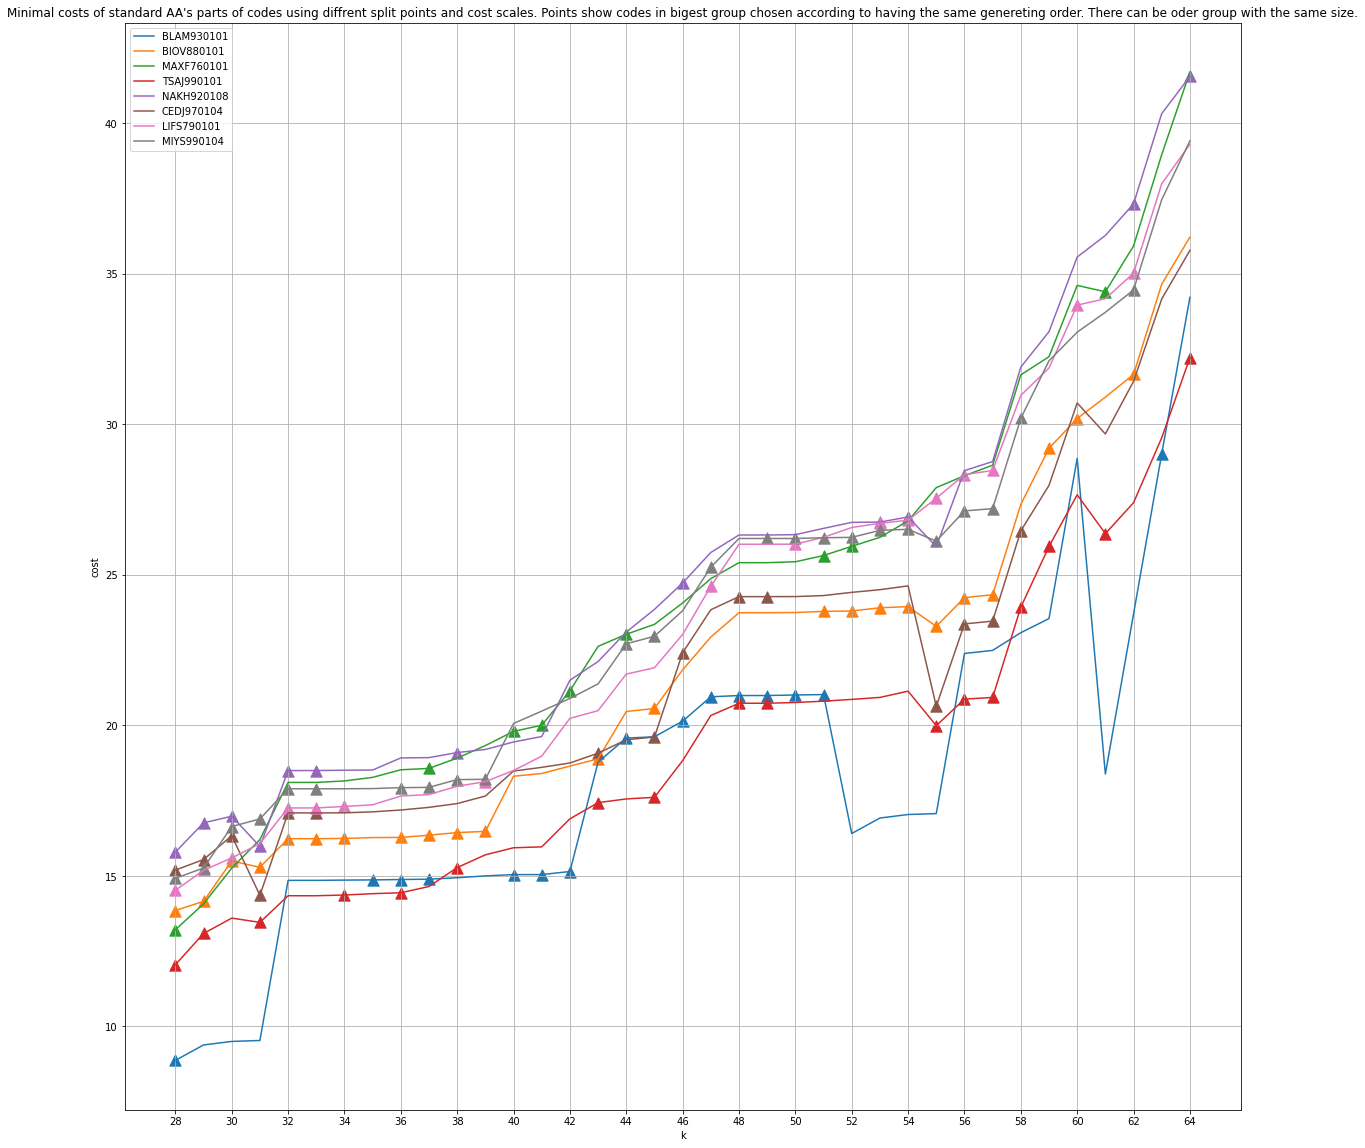

In [26]:
plt.gcf().set_size_inches((20,20))
for i in range(len(costsDictList)):
    mutationCostDict=costsDictList[i]
    costList, orderingList=plotMimimumCodeCostsForSeqentialSizes(mutationCostDict)
    costsOfCommons=[]
    for j in listOfSizesInWhichThisOrderBelongToBigestGroup[i]:
        costsOfCommons.append(costList[j-28])
    plt.scatter(listOfSizesInWhichThisOrderBelongToBigestGroup[i], costsOfCommons, marker='^', s=128)
plt.legend()
plt.xlabel("k")
plt.ylabel("cost")
plt.xticks(range(28,65,2))
plt.grid(True)
plt.title("Minimal costs of standard AA's parts of codes using diffrent split points and cost scales. Points show codes in bigest group chosen according to having the same genereting order. There can be oder group with the same size.")
plt.savefig("Obrazy/costsOfCodesWithSizeOfGroupsWithTheSameMinimalCode.png",dpi=1000)

# Analiza frontu Pareto

In [5]:
costsDictList=ccm.loadMutationCostDicts()

[0.96, 0.77, 0.39, 0.42, 0.42, 0.8, 0.53, 0.0, 0.57, 0.84, 0.92, 0.73, 0.86, 0.59, -2.5, 0.53, 0.54, 0.58, 0.72, 0.63]
['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
[16.0, -70.0, -74.0, -78.0, 168.0, -73.0, -106.0, -13.0, 50.0, 151.0, 145.0, -141.0, 124.0, 189.0, -20.0, -70.0, -38.0, 145.0, 53.0, 123.0]
['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
[1.43, 1.18, 0.64, 0.92, 0.94, 1.22, 1.67, 0.46, 0.98, 1.04, 1.36, 1.27, 1.53, 1.19, 0.49, 0.7, 0.78, 1.01, 0.69, 0.98]
['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
[89.3, 190.3, 122.4, 114.4, 102.5, 146.9, 138.8, 63.8, 157.5, 163.0, 163.1, 165.1, 165.8, 190.8, 121.6, 94.2, 119.6, 226.4, 194.6, 138.2]
['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
[9.36, 0.27, 2.31, 0.94, 2.56, 1.14, 0.94, 6.17, 0.47, 13.73, 16.64, 0.58, 3.93

In [12]:
normalizeByK=True
frontPareto={}
for mutationCostDict in costsDictList:
    allMinCodes=fun.generateAllMinCodes()
    setOfConsideredCodes=set()
    for k in range(28, 65):
        if k in allMinCodes:
            setOfConsideredCodes|=allMinCodes[k]
        for nucOrder, posOrder in setOfConsideredCodes:
            codonsList,aaList=fun.generateCodonsAndAA(nucOrder, posOrder)
            codonsList=codonsList[:k]
            aaList=aaList[:k]
            cost=calculateCodeCost(codonsList, aaList, mutationCostDict)
            if normalizeByK:
                cost/=k
            cond=fun.avarangeConductance(codonsList, aaList)
            frontPareto[(cost, cond, mutationCostDict)]=(nucOrder, posOrder, k)

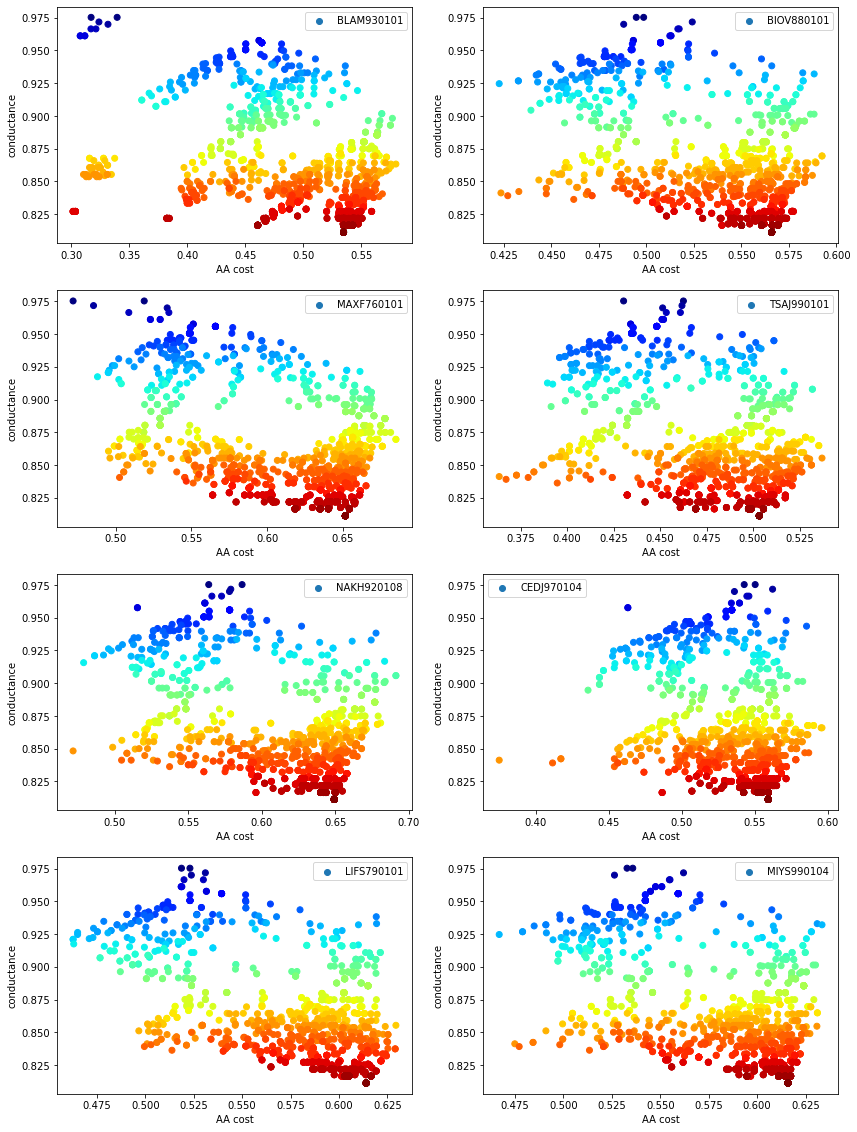

In [13]:
punkty={}
kolory={}
for cost, cond, mutationCostDict in frontPareto:
    nucOrd, posOrd, k=frontPareto[(cost, cond, mutationCostDict)]
    if mutationCostDict not in punkty:
        punkty[mutationCostDict]=[]
        kolory[mutationCostDict]=[]
    punkty[mutationCostDict].append((cost,cond))
    kolory[mutationCostDict].append(k)


plt.gcf().set_size_inches((14,20))
plt.title("Points represent diffrent orders. Colors represent diffrent k from 28 (dark blue) to 64 (dark red)")
i=0
for mutationCostDict in punkty:
    i+=1
    plt.subplot(4,2,i)
    podzbiorPunktow=np.array(punkty[mutationCostDict])
    plt.scatter(podzbiorPunktow[:,0], podzbiorPunktow[:,1],
                c=kolory[mutationCostDict], cmap="jet", label=mutationCostDict.name)
    plt.xlabel("AA cost")
    plt.ylabel("conductance")
    plt.legend()

plt.savefig("Obrazy/frontPareto.png", dpi=700)

In [15]:
for cost, cond, mutationCostDict in frontPareto:
    if cost<0.32 and cond<0.84:
        print(cost, cond)
        print(frontPareto[(cost, cond, mutationCostDict)])
        print("-------------")

0.30339905535998024 0.8271604938271605
(('A', 'G', 'T', 'C'), (2, 1, 3), 61)
-------------
0.30139280450070627 0.8271604938271605
(('T', 'G', 'A', 'C'), (1, 2, 3), 61)
-------------
0.3013928045007063 0.8271604938271605
(('T', 'A', 'G', 'C'), (2, 1, 3), 61)
-------------
0.3033990553599803 0.8271604938271605
(('G', 'T', 'A', 'C'), (1, 2, 3), 61)
-------------
0.30139280450070616 0.8271604938271606
(('T', 'G', 'A', 'C'), (2, 1, 3), 61)
-------------
0.3033990553599801 0.8271604938271605
(('A', 'G', 'T', 'C'), (1, 2, 3), 61)
-------------
0.30339905535998 0.8271604938271606
(('G', 'T', 'A', 'C'), (2, 1, 3), 61)
-------------
0.30339905535998024 0.8271604938271603
(('A', 'T', 'G', 'C'), (2, 1, 3), 61)
-------------
0.30339905535998013 0.8271604938271606
(('G', 'A', 'T', 'C'), (2, 1, 3), 61)
-------------
0.30139280450070643 0.8271604938271603
(('T', 'A', 'G', 'C'), (1, 2, 3), 61)
-------------
0.3033990553599804 0.8271604938271605
(('A', 'T', 'G', 'C'), (1, 2, 3), 61)
-------------


# Kody z TGA

In [14]:
normalizeByK=True
frontParetoZTGA={}
for mutationCostDict in costsDictList:
    allMinCodes=fun.generateAllMinCodes()
    setOfConsideredCodes=set()
    for k in range(28, 65):
        if k in allMinCodes:
            setOfConsideredCodes|=allMinCodes[k]
        for nucOrder, posOrder in setOfConsideredCodes:
            codonsList,aaList=fun.generateCodonsAndAA(nucOrder, posOrder)
            codonsList=codonsList[:k]
            if "TGA" not in codonsList:
                continue
            aaList=aaList[:k]
            cost=calculateCodeCost(codonsList, aaList, mutationCostDict)
            if normalizeByK:
                cost/=k
            cond=fun.avarangeConductance(codonsList, aaList)
            frontParetoZTGA[(cost, cond, mutationCostDict)]=(nucOrder, posOrder, k)

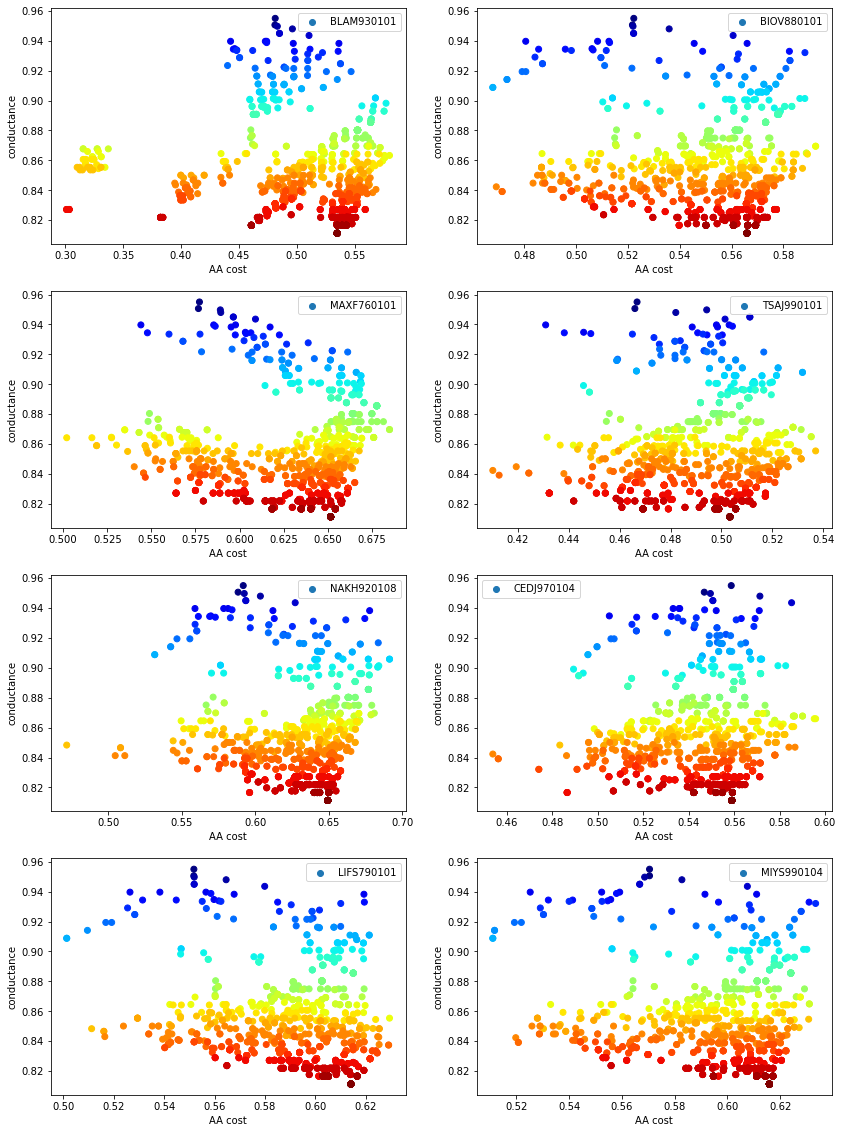

In [15]:
punkty={}
kolory={}
for cost, cond, mutationCostDict in frontParetoZTGA:
    nucOrd, posOrd, k=frontParetoZTGA[(cost, cond, mutationCostDict)]
    if mutationCostDict not in punkty:
        punkty[mutationCostDict]=[]
        kolory[mutationCostDict]=[]
    punkty[mutationCostDict].append((cost,cond))
    kolory[mutationCostDict].append(k)


plt.gcf().set_size_inches((14,20))
plt.title("Points represent diffrent orders. Colors represent diffrent k from 28 (dark blue) to 64 (dark red)")
i=0
for mutationCostDict in punkty:
    i+=1
    plt.subplot(4,2,i)
    podzbiorPunktow=np.array(punkty[mutationCostDict])
    plt.scatter(podzbiorPunktow[:,0], podzbiorPunktow[:,1],
                c=kolory[mutationCostDict], cmap="jet", label=mutationCostDict.name)
    plt.xlabel("AA cost")
    plt.ylabel("conductance")
    plt.legend()

plt.savefig("Obrazy/frontParetoZTGA.png", dpi=700)

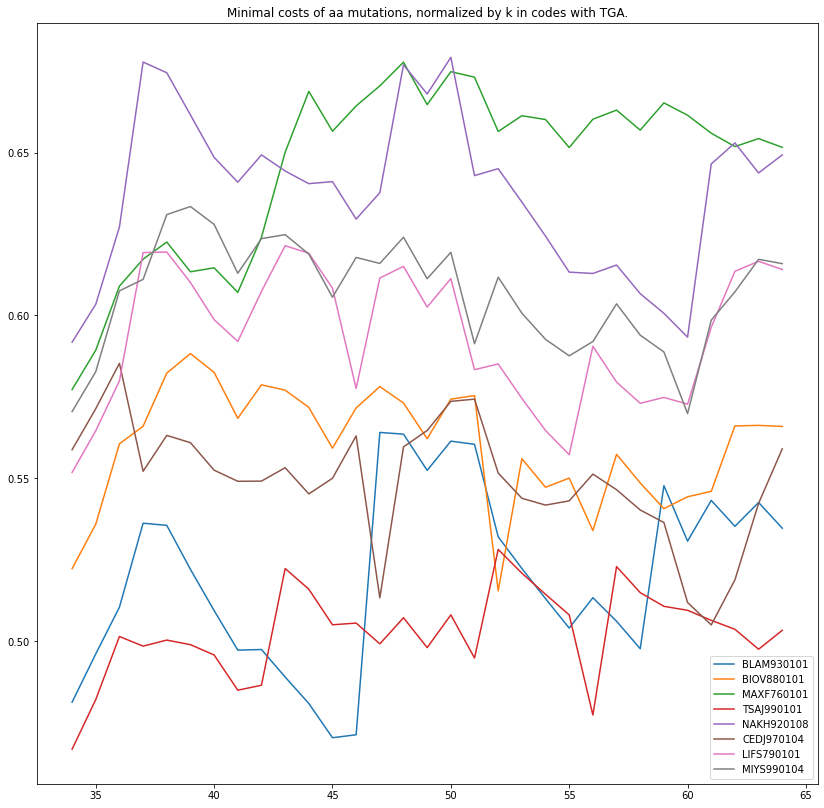

In [17]:
plt.gcf().set_size_inches((14,14))
minimalneKoszty={}
minimalnePorzadki={}
for cost, cond, mutationCostDict in frontParetoZTGA:
    nucOrd, posOrd, k=frontParetoZTGA[(cost, cond, mutationCostDict)]
    if mutationCostDict not in minimalneKoszty:
        minimalneKoszty[mutationCostDict]={}
        minimalnePorzadki[mutationCostDict]={}
    if k in minimalneKoszty[mutationCostDict] and cost<minimalneKoszty[mutationCostDict][k]:
        minimalneKoszty[mutationCostDict][k]=cost
        minimalnePorzadki[mutationCostDict][k]={(nucOrd, posOrd)}
    else:
        minimalneKoszty[mutationCostDict][k]=cost
        minimalnePorzadki[mutationCostDict][k]={(nucOrd, posOrd)}
        
common={}
for mutationCostDict in minimalnePorzadki:
    common[mutationCostDict]=[]
    for i in range(len(bestCondOrderingList)):
        if i+28 in minimalneKoszty[mutationCostDict] and \
                len((bestCondOrderingList[i] & minimalnePorzadki[mutationCostDict][i+28]))>0:
            common[mutationCostDict].append(i+28)
            
for mutationCostDict in minimalneKoszty:
    plt.plot(list(minimalneKoszty[mutationCostDict].keys()), 
             list(minimalneKoszty[mutationCostDict].values()),
             label=mutationCostDict.name)
plt.legend()
plt.title("Minimal costs of aa mutations, normalized by k in codes with TGA.")

plt.savefig("Obrazy/aaMutationCostsInCodesWithTGA.png", dpi=700)

In [55]:
common

{<createCostsMatrix.aaMutationCostsDict at 0x7f7daf841940>: [63, 64],
 <createCostsMatrix.aaMutationCostsDict at 0x7f7daf27cac0>: [63, 64],
 <createCostsMatrix.aaMutationCostsDict at 0x7f7db42a5ac0>: [63, 64],
 <createCostsMatrix.aaMutationCostsDict at 0x7f7daf2da700>: [63],
 <createCostsMatrix.aaMutationCostsDict at 0x7f7daf2da760>: [63, 64],
 <createCostsMatrix.aaMutationCostsDict at 0x7f7daf2daac0>: [63, 64],
 <createCostsMatrix.aaMutationCostsDict at 0x7f7daf2daaf0>: [],
 <createCostsMatrix.aaMutationCostsDict at 0x7f7daf2c06d0>: [63, 64]}

# Analizy dalsze

## Średnia z 8 skal

In [6]:
T=fun.generateAllMinCodes()
i=0
for k in T:
    for nucOrd, posOrd in T[k]:
        codonsList,aaList=fun.generateCodonsAndAA(nucOrd, posOrd)
        codonsList=codonsList[:k]
        if np.any(codonsList=="TAG"):
            i+=1
print(i)

144


In [7]:
def findMinimumMeanCostForDiffrentOrderings(setOfOrderings, k, mutationCostDictList, ifTAGisSTOP=True,
                                           normalizeByK=False):
    minimumCost=np.inf
    minimumOrder=set()
    for nucOrder,posOrder in setOfOrderings:
        cost=0
        codonsList,aaList=fun.generateCodonsAndAA(nucOrder, posOrder)
        codonsList=codonsList[:k]
        aaList=aaList[:k]
        ifTAG=np.any(codonsList=="TAG")
        if ifTAGisSTOP and not ifTAG:
            continue
        if (not ifTAGisSTOP) and ifTAG:
            continue
        for mutationCostDict in mutationCostDictList:
            cost+=calculateCodeCost(codonsList, aaList, mutationCostDict)
        cost/=len(mutationCostDictList)
        if normalizeByK:
            cost/=k
        if cost<minimumCost:
            minimumCost=cost
            minimumOrder=set()
        if cost==minimumCost:
            minimumOrder.add((nucOrder, posOrder))
    return minimumCost, minimumOrder

In [8]:
def applyFunctionForSequentialSizes(f,startK=28):
    results=[]
    allMinCodes=fun.generateAllMinCodes()
    setOfConsideredCodes=set()
    for k in range(0, startK):
        if k in allMinCodes:
            setOfConsideredCodes|=allMinCodes[k]
    for k in range(startK, 65):
        if k in allMinCodes:
            setOfConsideredCodes|=allMinCodes[k]
        results.append(f(setOfConsideredCodes,k))
    return results

In [9]:
def plotMeanCost(normalizeByK=False, ifTAGisSTOP=True):
    results=applyFunctionForSequentialSizes(lambda x,y:findMinimumMeanCostForDiffrentOrderings(x,y,costsDictList,
                                                                                              ifTAGisSTOP=ifTAGisSTOP,
                                                                                              normalizeByK=normalizeByK))
    costs=[]
    indexes=[]
    for i in range(len(results)):
        cost, orderings=results[i]
        if cost ==np.inf:
            continue
        costs.append(cost)
        indexes.append(i+28)
    print(len(costs))
    plt.plot(indexes, costs, label="Norm: "+str(normalizeByK)+" TAG is STOP: "+str(ifTAGisSTOP))

37


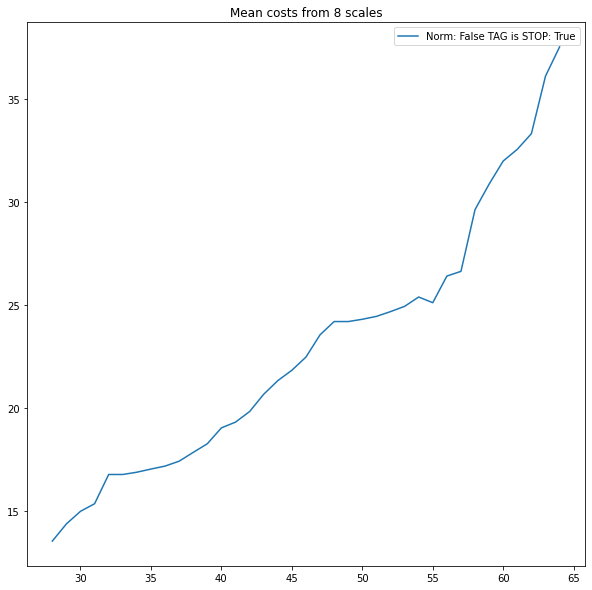

In [10]:
plt.gcf().set_size_inches((10,10))

plotMeanCost(normalizeByK=False, ifTAGisSTOP=True)
#plotMeanCost(normalizeByK=False, ifTAGisSTOP=False)
plt.legend()
plt.title("Mean costs from 8 scales")
plt.savefig("Obrazy/meanCostFrom8Scales.pdf", dpi=500)

37


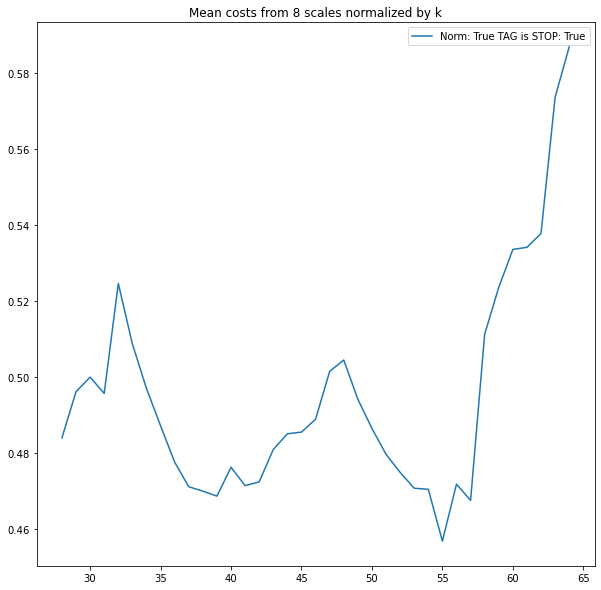

In [11]:
plt.gcf().set_size_inches((10,10))
plotMeanCost(normalizeByK=True, ifTAGisSTOP=True)
#plotMeanCost(normalizeByK=True, ifTAGisSTOP=False)
plt.legend()
plt.title("Mean costs from 8 scales normalized by k")
plt.savefig("Obrazy/meanCostFrom8ScalesNormalizedByK.pdf", dpi=500)

## Grantham

In [27]:
granthamScale=ccm.loadMutationCostDictsFromMatrix()

In [16]:
def plotGranthamCost(normalizeByK=False, ifTAGisSTOP=True):
    results=applyFunctionForSequentialSizes(lambda x,y:findMinimumMeanCostForDiffrentOrderings(x,y,granthamScale,
                                                                                              ifTAGisSTOP=ifTAGisSTOP,
                                                                                              normalizeByK=normalizeByK))
    costs=[]
    indexes=[]
    for i in range(len(results)):
        cost, orderings=results[i]
        if cost ==np.inf:
            continue
        costs.append(cost)
        indexes.append(i+28)
    plt.plot(indexes, costs, label="Norm: "+str(normalizeByK)+" TAG is STOP: "+str(ifTAGisSTOP))

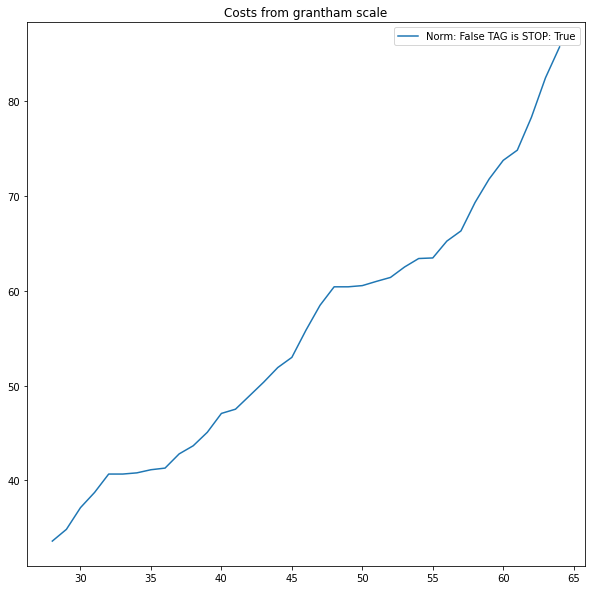

In [17]:
plt.gcf().set_size_inches((10,10))

plotGranthamCost(normalizeByK=False, ifTAGisSTOP=True)
#plotGranthamCost(normalizeByK=False, ifTGAisSTOP=False)
plt.legend()
plt.title("Costs from grantham scale")
plt.savefig("Obrazy/costFromGrnthamScale.png", dpi=500)

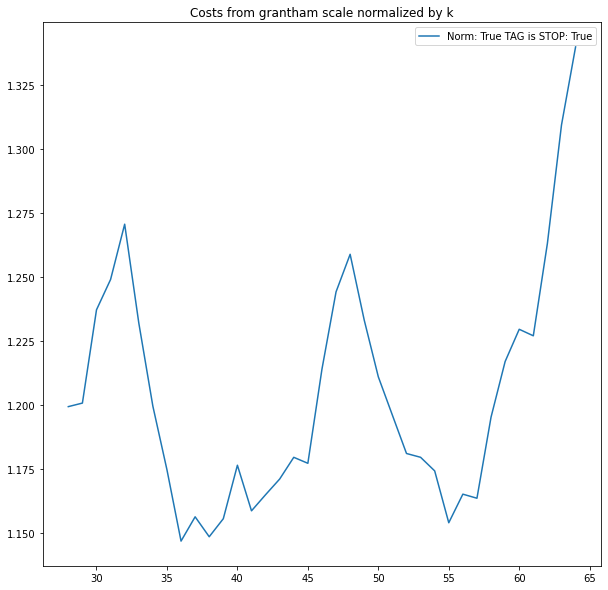

In [18]:
plt.gcf().set_size_inches((10,10))

plotGranthamCost(normalizeByK=True, ifTAGisSTOP=True)
#plotGranthamCost(normalizeByK=True, ifTGAisSTOP=False)
plt.legend()
plt.title("Costs from grantham scale normalized by k")
plt.savefig("Obrazy/costFromGrnthamScaleNormalizedByK.png", dpi=500)

## Polarity

In [28]:
polarityScale=ccm.loadMutationCostDicts("./scales/polarity.csv")

[6.5, 8.6, 9.6, 12.2, 4.3, 8.9, 13.6, 9.0, 7.9, 5.0, 4.4, 10.2, 5.0, 4.5, 6.1, 7.5, 6.2, 4.9, 7.7, 6.2]
['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']


In [20]:
def plotPolarityCost(normalizeByK=False, ifTAGisSTOP=True):
    results=applyFunctionForSequentialSizes(lambda x,y:findMinimumMeanCostForDiffrentOrderings(x,y,polarityScale,
                                                                                              ifTAGisSTOP=ifTAGisSTOP,
                                                                                              normalizeByK=normalizeByK))
    costs=[]
    indexes=[]
    for i in range(len(results)):
        cost, orderings=results[i]
        if cost ==np.inf:
            continue
        costs.append(cost)
        indexes.append(i+28)
    plt.plot(indexes, costs, label="Norm: "+str(normalizeByK)+" TAG is STOP: "+str(ifTAGisSTOP))

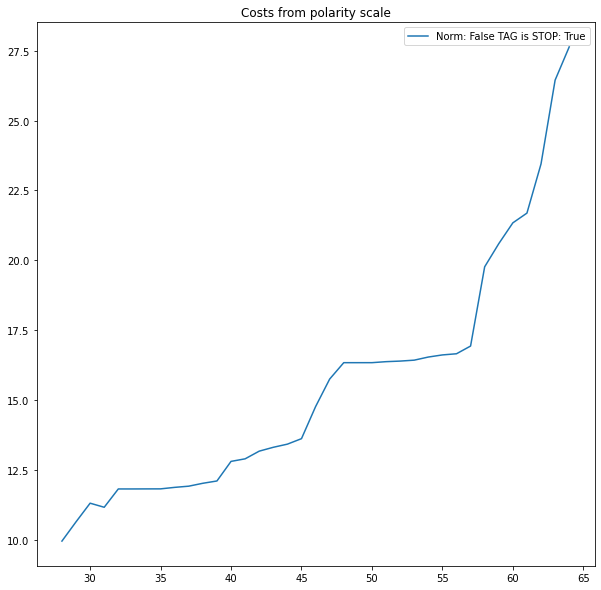

In [21]:
plt.gcf().set_size_inches((10,10))

plotPolarityCost(normalizeByK=False, ifTAGisSTOP=True)
#plotPolarityCost(normalizeByK=False, ifTAGisSTOP=False)
plt.legend()
plt.title("Costs from polarity scale")
plt.savefig("Obrazy/costFromPolarityScale.png", dpi=500)

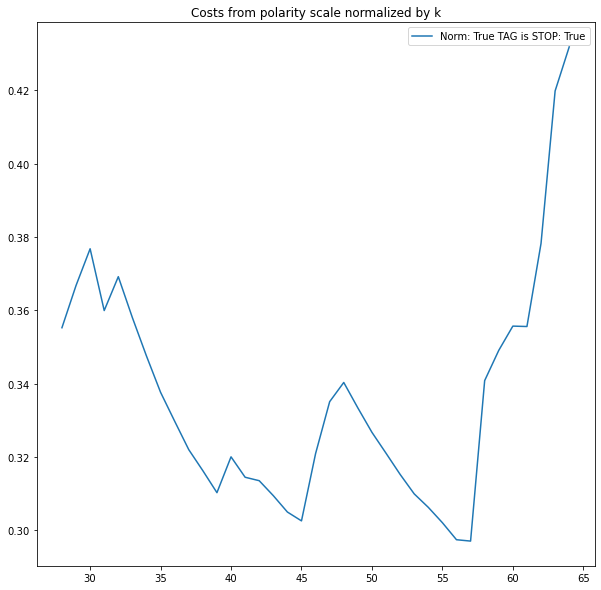

In [22]:
plt.gcf().set_size_inches((10,10))

plotPolarityCost(normalizeByK=True, ifTAGisSTOP=True)
#plotPolarityCost(normalizeByK=True, ifTAGisSTOP=False)
plt.legend()
plt.title("Costs from polarity scale normalized by k")
plt.savefig("Obrazy/costFromPolarityScaleNormalizedByK.png", dpi=500)

## Wykres łączny

37


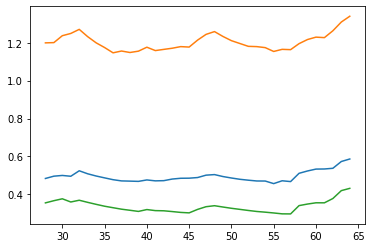

In [23]:
plotMeanCost(normalizeByK=True, ifTAGisSTOP=True)
#plotMeanCost(normalizeByK=True, ifTAGisSTOP=False)
plotGranthamCost(normalizeByK=True, ifTAGisSTOP=True)
#plotGranthamCost(normalizeByK=True, ifTAGisSTOP=False)
plotPolarityCost(normalizeByK=True, ifTAGisSTOP=True)
#plotPolarityCost(normalizeByK=True, ifTAGisSTOP=False)

## Te same kody

In [24]:
def returnCommon(normalizeByK=False, ifTAGisSTOP=True, printNumbers=None):
    resultsCosts8=applyFunctionForSequentialSizes(lambda x,y:findMinimumMeanCostForDiffrentOrderings(x,y,costsDictList,
                                                                                                  ifTAGisSTOP=ifTAGisSTOP,
                                                                                                  normalizeByK=normalizeByK))
    resultsGrantham=applyFunctionForSequentialSizes(lambda x,y:findMinimumMeanCostForDiffrentOrderings(x,y,granthamScale,
                                                                                                  ifTAGisSTOP=ifTAGisSTOP,
                                                                                                  normalizeByK=normalizeByK))
    resultsPolarity=applyFunctionForSequentialSizes(lambda x,y:findMinimumMeanCostForDiffrentOrderings(x,y,polarityScale,
                                                                                                  ifTAGisSTOP=ifTAGisSTOP,
                                                                                                  normalizeByK=normalizeByK))
    if printNumbers is not None:
        for nr in printNumbers:
            print(resultsCosts8[nr-28][1], resultsGrantham[nr-28][1], resultsPolarity[nr-28][1])
    listOfCommonNumbers=[]
    for a,b,c in zip(resultsCosts8, resultsGrantham, resultsPolarity):
        if a[0]==b[0]==c[0]==np.inf:
            listOfCommonNumbers.append(0)
            continue
        if (a[1] & b[1] & c[1]) != set():
            listOfCommonNumbers.append(3)
            continue
        if ((a[1] & b[1]) != set()) or ((a[1] & c[1]) != set()) or ((b[1] & c[1]) != set()):
            listOfCommonNumbers.append(2)
            continue
        listOfCommonNumbers.append(1)
    return listOfCommonNumbers

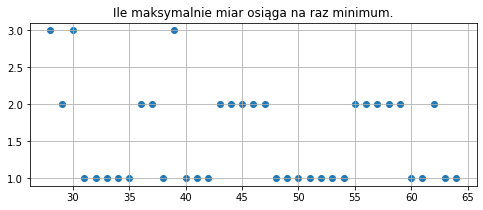

In [30]:
plt.gcf().set_size_inches((8,3))
plt.scatter(np.arange(28,65),returnCommon())
plt.grid(True)
plt.title("Ile maksymalnie miar osiąga na raz minimum.")
plt.savefig("Obrazy/maksymalnaLiczbaMinimow.png",dpi=500)

In [26]:
L=returnCommon(printNumbers=[39])

{(('C', 'G', 'A', 'T'), (3, 2, 1))} {(('C', 'G', 'A', 'T'), (3, 2, 1))} {(('C', 'G', 'A', 'T'), (3, 2, 1))}


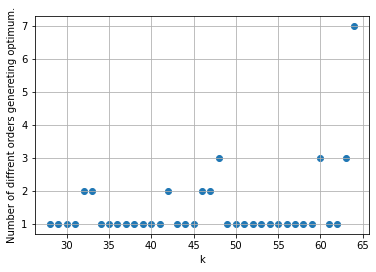

In [22]:
def plotNumberOfBestCodesForEachK(results):
    numbers=[]
    for k in range(len(results)):
        numbers.append((k+28,len(results[k][1])))
    numbers.sort()
    numbers=np.array(numbers)
    
    plt.scatter(numbers[:,0], numbers[:,1])
    plt.grid(True)
    plt.ylabel("Number of diffrent orders genereting optimum.")
    plt.xlabel("k")
    
plotNumberOfBestCodesForEachK(applyFunctionForSequentialSizes(lambda x,y:findMinimumMeanCostForDiffrentOrderings(x,y,costsDictList,
                                                                                                  ifTAGisSTOP=True,
                                                                                                  normalizeByK=True)))
plt.savefig("Obrazy/numberOfDiffrentBestOrderingsForDiffrentKForMeanCost8.pdf",dpi=500)

# Print codes

In [27]:
def printResultCodes(normalizeByK=False, ifTAGisSTOP=True):
    resultsCosts8=applyFunctionForSequentialSizes(lambda x,y:findMinimumMeanCostForDiffrentOrderings(x,y,costsDictList,
                                                                                                  ifTAGisSTOP=ifTAGisSTOP,
                                                                                                  normalizeByK=normalizeByK))
    resultsGrantham=applyFunctionForSequentialSizes(lambda x,y:findMinimumMeanCostForDiffrentOrderings(x,y,granthamScale,
                                                                                                  ifTAGisSTOP=ifTAGisSTOP,
                                                                                                  normalizeByK=normalizeByK))
    resultsPolarity=applyFunctionForSequentialSizes(lambda x,y:findMinimumMeanCostForDiffrentOrderings(x,y,polarityScale,
                                                                                                  ifTAGisSTOP=ifTAGisSTOP,
                                                                                                  normalizeByK=normalizeByK))
    directory="optymalneKody"
    if not os.path.isdir(directory):
        os.mkdir(directory)
    for i in range(len(resultsCosts8)):
        result=resultsCosts8[i]
        for nucOrder, posOrder in result[1]:
            plik=open(directory+"/"+"costs8"+"_"+"k"+str(i+28)+"_"+''.join(nucOrder)+"_"+''.join(str(i) for i in posOrder)+"_"+"TAGStop"+str(ifTAGisSTOP)+".tex", "w")
            fun.printCode(nucOrder, posOrder, i+28, file=plik)
            plik.close()
    for i in range(len(resultsGrantham)):
        result=resultsGrantham[i]
        for nucOrder, posOrder in result[1]:
            plik=open(directory+"/"+"grantham"+"_"+"k"+str(i+28)+"_"+''.join(nucOrder)+"_"+''.join(str(i) for i in posOrder)+"_"+"TAGStop"+str(ifTAGisSTOP)+".tex", "w")
            fun.printCode(nucOrder, posOrder, i+28, file=plik)
            plik.close()
    for i in range(len(resultsPolarity)):
        result=resultsPolarity[i]
        for nucOrder, posOrder in result[1]:
            plik=open(directory+"/"+"polarity"+"_"+"k"+str(i+28)+"_"+''.join(nucOrder)+"_"+''.join(str(i) for i in posOrder)+"_"+"TAGStop"+str(ifTAGisSTOP)+".tex", "w")
            fun.printCode(nucOrder, posOrder, i+28, file=plik)
            plik.close()

In [28]:
printResultCodes(ifTAGisSTOP=True)

# Print numerical results

In [31]:
def printNumericalResults(normalizeByK=False, ifTAGisSTOP=True):
    resultsCosts8=applyFunctionForSequentialSizes(lambda x,y:findMinimumMeanCostForDiffrentOrderings(x,y,costsDictList,
                                                                                                  ifTAGisSTOP=ifTAGisSTOP,
                                                                                                  normalizeByK=normalizeByK))
    resultsGrantham=applyFunctionForSequentialSizes(lambda x,y:findMinimumMeanCostForDiffrentOrderings(x,y,granthamScale,
                                                                                                  ifTAGisSTOP=ifTAGisSTOP,
                                                                                                  normalizeByK=normalizeByK))
    resultsPolarity=applyFunctionForSequentialSizes(lambda x,y:findMinimumMeanCostForDiffrentOrderings(x,y,polarityScale,
                                                                                                  ifTAGisSTOP=ifTAGisSTOP,
                                                                                                  normalizeByK=normalizeByK))
    directory="wynikiNumeryczne"
    if not os.path.isdir(directory):
        os.mkdir(directory)
    with open(directory+"/"+"costs8.txt", "w") as plik:
        results=[]
        for k in range(0,len(resultsCosts8)):
            results.append((k+28,resultsCosts8[k][0],resultsCosts8[k][1]))
        for a,b,c in results:
            print(a,b,c, file=plik)
    with open(directory+"/"+"grantham.txt", "w") as plik:
        results=[]
        for k in range(0,len(resultsGrantham)):
            results.append((k+28,resultsGrantham[k][0],resultsGrantham[k][1]))
        for a,b,c in results:
            print(a,b,c, file=plik)
    with open(directory+"/"+"polarity.txt", "w") as plik:
        results=[]
        for k in range(0,len(resultsPolarity)):
            results.append((k+28,resultsPolarity[k][0],resultsPolarity[k][1]))
        for a,b,c in results:
            print(a,b,c, file=plik)

In [32]:
printNumericalResults(True,True)